In [1]:
import os
import cv2 as cv
import numpy as np
from time import time
import matplotlib.pyplot as plt

In [2]:
images = []
for file in os.listdir("images"):
    image = cv.imread("images/" + file)
    images.append(image)

In [3]:
def get_harris_corners(img):
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv.cornerHarris(gray,2,3,0.2)
    dst = cv.dilate(dst,None)
    kps = (dst > 0.01 * dst.max()).nonzero()
    return np.transpose(dst[kps]), len(np.transpose(kps))

def get_sift_features(img):
    descriptor = cv.SIFT_create()
    (kps, features) = descriptor.detectAndCompute(img, None)
    return features, len(kps)

def get_orb_features(img):
    descriptor = cv.ORB_create()
    (kps, features) = descriptor.detectAndCompute(img, None)
    return features, len(kps)

In [4]:
def get_images_features(images, method):
    images_features = [] 
    all_kps_len = 0
    for img in images:
        features, kps_len = method(img)
        images_features.append(features)
        all_kps_len += kps_len
    return images_features, all_kps_len

In [5]:
t1 = time()
harris_features, kps_len = get_images_features(images, get_harris_corners)
t2 = time()
print(f'Среднее время Harris: {np.round((t2 - t1) / kps_len * 1000, 6)} мсек/точка')

Среднее время Harris: 0.001607 мсек/точка


In [6]:
t1 = time()
sift_features, kps_len = get_images_features(images, get_sift_features)
t2 = time()
print(f'Среднее время SIFT: {np.round((t2 - t1) / kps_len * 1000, 6)} мсек/точка')

Среднее время SIFT: 0.042342 мсек/точка


In [7]:
t1 = time()
orb_features, kps_len = get_images_features(images, get_orb_features)
t2 = time()
print(f'Среднее время ORB: {np.round((t2 - t1) / kps_len * 1000, 6)} мсек/точка')

Среднее время ORB: 0.040068 мсек/точка


In [8]:
def get_repeatability(features, norm=cv.NORM_L2):   
    bruteforce = cv.BFMatcher(norm, crossCheck=True)
    repeatabilities = []
    for i, features1 in enumerate(features):
        repeats_count = np.zeros(len(features1))
        for j, features2 in enumerate(features):
            if i != j:
                matches = bruteforce.match(features1, features2)
                for match in matches:
                    repeats_count[match.queryIdx] += 1
        repeatability = (repeats_count / (len(features) - 1)).mean()
        repeatabilities.append(repeatability)
    return repeatabilities

In [9]:
harris_repeatabilities = get_repeatability(harris_features)
sift_repeatabilities = get_repeatability(sift_features)
orb_repeatabilities = get_repeatability(orb_features, cv.NORM_HAMMING)

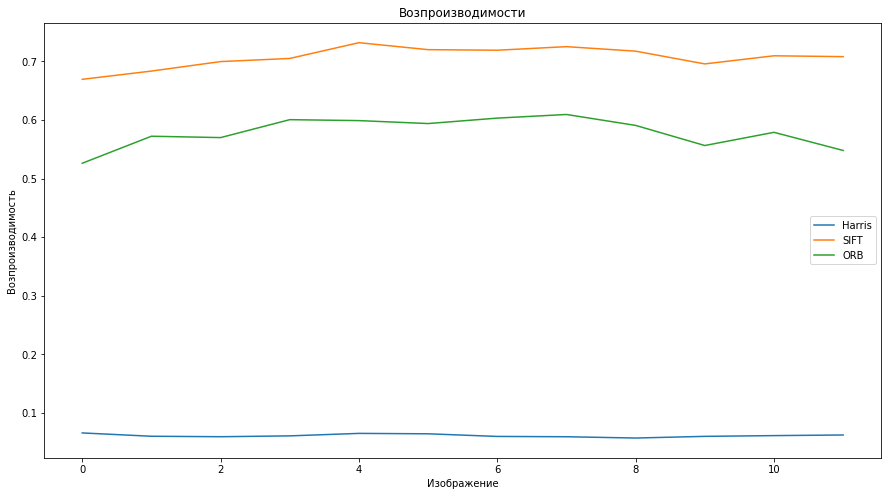

In [10]:
plt.figure(figsize=(15, 8))
plt.title('Возпроизводимости')
plt.plot(harris_repeatabilities, label='Harris')
plt.plot(sift_repeatabilities, label='SIFT')
plt.plot(orb_repeatabilities, label='ORB')

plt.xlabel("Изображение")
plt.ylabel("Возпроизводимость")
plt.legend()
plt.show()

***Вывод:***

Детектор SIFT на данных изображениях показывает наиболее хороший результат воспроизводимости, чем Harris и ORB. Однако, Harris является самым быстрым, хоть и имеет наихудшую воспроизводимость.